# Four-qubit Schwinger model

In [8]:
import numpy as np
from qiskit import IBMQ, QuantumCircuit, pulse, transpile
from qiskit.circuit import Gate, Parameter

from calibrations import LinearizedCR, cx_circuit

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research', group='tokyo-1', project='main')
backend = provider.get_backend('ibm_lagos')

In [3]:
J = 1. # Hamiltonian J parameter
mu = 0.5 # Hamiltonian mu parameter

M = 10 # number of Trotter steps
omegadt = 0.2 # Trotter step size

In [4]:
nsites = 4

phi = Parameter('phi')

def single_step(J, mu, omegadt):
    """Naive single-step circuit for reference.
    """
    
    circuit = QuantumCircuit(nsites)
    
    for j in range(nsites - 1):
        circuit.rxx(omegadt, j, j + 1)
        circuit.ryy(omegadt, j, j + 1)

        for k in range(j):
            circuit.rzz(J * (nsites - j - 1) * omegadt, k, j)
            
    for j in range(nsites):
        angle = (mu * (-1. if j % 2 == 0 else 1.) - J * ((nsites - j) // 2)) * omegadt
        circuit.rz(angle, j)
        
    return circuit

def two_steps(J, mu, omegadt, crs=None, cxs=None):
    circuit = QuantumCircuit(nsites)
    
    # First step
    
    for j in range(nsites):
        angle = (mu * (-1. if j % 2 == 0 else 1.) - J * ((nsites - j) // 2)) * omegadt
        circuit.rz(angle, j)

    if crs is None:
        circuit.rxx(omegadt, 0, 1)
        circuit.ryy(omegadt, 0, 1)
        circuit.rxx(omegadt, 2, 3)
        circuit.ryy(omegadt, 2, 3)
        circuit.rxx(omegadt, 1, 2)
        circuit.ryy(omegadt, 1, 2)
        circuit.rzz(omegadt, 1, 2)
    else:
        circuit.compose(crs[(0, 1)].rxx_circuit(omegadt), qubits=(0, 1), inplace=True)
        circuit.compose(crs[(0, 1)].ryy_circuit(omegadt), qubits=(0, 1), inplace=True)
        circuit.compose(crs[(2, 3)].rxx_circuit(omegadt), qubits=(2, 3), inplace=True)
        circuit.compose(crs[(2, 3)].ryy_circuit(omegadt), qubits=(2, 3), inplace=True)
        circuit.compose(crs[(1, 2)].rxx_circuit(omegadt), qubits=(1, 2), inplace=True)
        circuit.compose(crs[(1, 2)].ryy_circuit(omegadt), qubits=(1, 2), inplace=True)
        circuit.compose(crs[(1, 2)].rzz_circuit(omegadt), qubits=(1, 2), inplace=True)
    
    ## rzz(2 * omegadt, 0, 1)
    if cxs is None:
        circuit.cx(0, 1)
    else:
        circuit.compose(cxs[(0, 1)], qubits=(0, 1), inplace=True)
    circuit.rz(2 * omegadt, 1)
    #circuit.cx(0, 1)

    ## rzz(omegadt, 0, 2)
    #circuit.cx(0, 1)
    if cxs is None:
        circuit.cx(1, 0)
        circuit.cx(0, 1)
    else:
        circuit.compose(cxs[(1, 0)], qubits=(1, 0), inplace=True)
        circuit.compose(cxs[(0, 1)], qubits=(0, 1), inplace=True)
    #circuit.rzz(omegadt, 1, 2)
    #circuit.cx(0, 1)
    #circuit.cx(1, 0)
    #circuit.cx(0, 1)

    if crs is None:
        circuit.rzz(2 * omegadt, 1, 2)
    else:
        circuit.compose(crs[(1, 2)].rzz_circuit(2 * omegadt), qubits=(1, 2), inplace=True)
    
    # Second step

    # rzz(omegadt, 0, 2)
    #circuit.cx(0, 1)
    #circuit.cx(1, 0)
    #circuit.cx(0, 1)
    #circuit.rzz(omegadt, 1, 2)
    if cxs is None:
        circuit.cx(0, 1)
        circuit.cx(1, 0)
    else:
        circuit.compose(cxs[(0, 1)], qubits=(0, 1), inplace=True)
        circuit.compose(cxs[(1, 0)], qubits=(1, 0), inplace=True)
    #circuit.cx(0, 1)
    
    # rzz(2 * omegadt, 0, 1)
    #circuit.cx(0, 1)
    circuit.rz(2 * omegadt, 1)
    if cxs is None:
        circuit.cx(0, 1)
    else:
        circuit.compose(cxs[(0, 1)], qubits=(0, 1), inplace=True)

    if crs is None:
        circuit.rxx(omegadt, 1, 2)
        circuit.ryy(omegadt, 1, 2)
        circuit.rzz(omegadt, 1, 2)
        circuit.rxx(omegadt, 0, 1)
        circuit.ryy(omegadt, 0, 1)
        circuit.rxx(omegadt, 2, 3)
        circuit.ryy(omegadt, 2, 3)
    else:
        circuit.compose(crs[(1, 2)].rxx_circuit(omegadt), qubits=(1, 2), inplace=True)
        circuit.compose(crs[(1, 2)].ryy_circuit(omegadt), qubits=(1, 2), inplace=True)
        circuit.compose(crs[(1, 2)].rzz_circuit(omegadt), qubits=(1, 2), inplace=True)
        circuit.compose(crs[(0, 1)].rxx_circuit(omegadt), qubits=(0, 1), inplace=True)
        circuit.compose(crs[(0, 1)].ryy_circuit(omegadt), qubits=(0, 1), inplace=True)
        circuit.compose(crs[(2, 3)].rxx_circuit(omegadt), qubits=(2, 3), inplace=True)
        circuit.compose(crs[(2, 3)].ryy_circuit(omegadt), qubits=(2, 3), inplace=True)
       
    for j in range(nsites):
        phi = (mu * (-1. if j % 2 == 0 else 1.) - J * ((nsites - j) // 2)) * omegadt
        circuit.rz(phi, j)
        
    return circuit

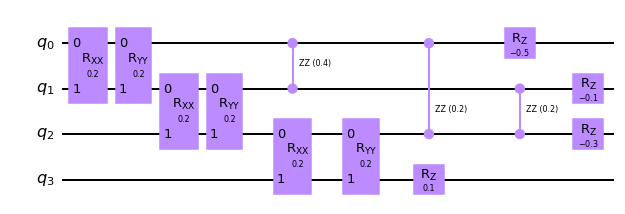

In [5]:
naive_ref = single_step(J, mu, omegadt)
naive_ref.draw('mpl')

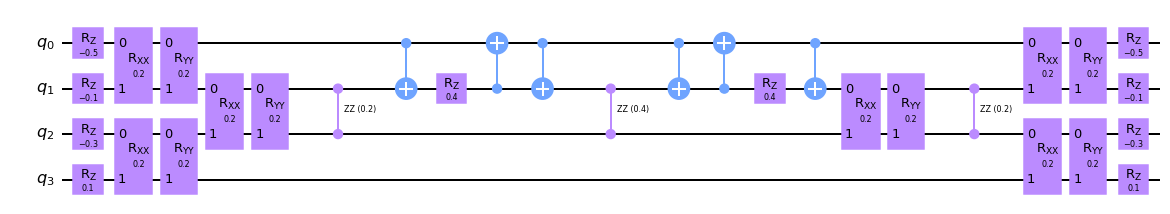

In [6]:
optimized_twostep = two_steps(J, mu, omegadt)
optimized_twostep.draw('mpl')

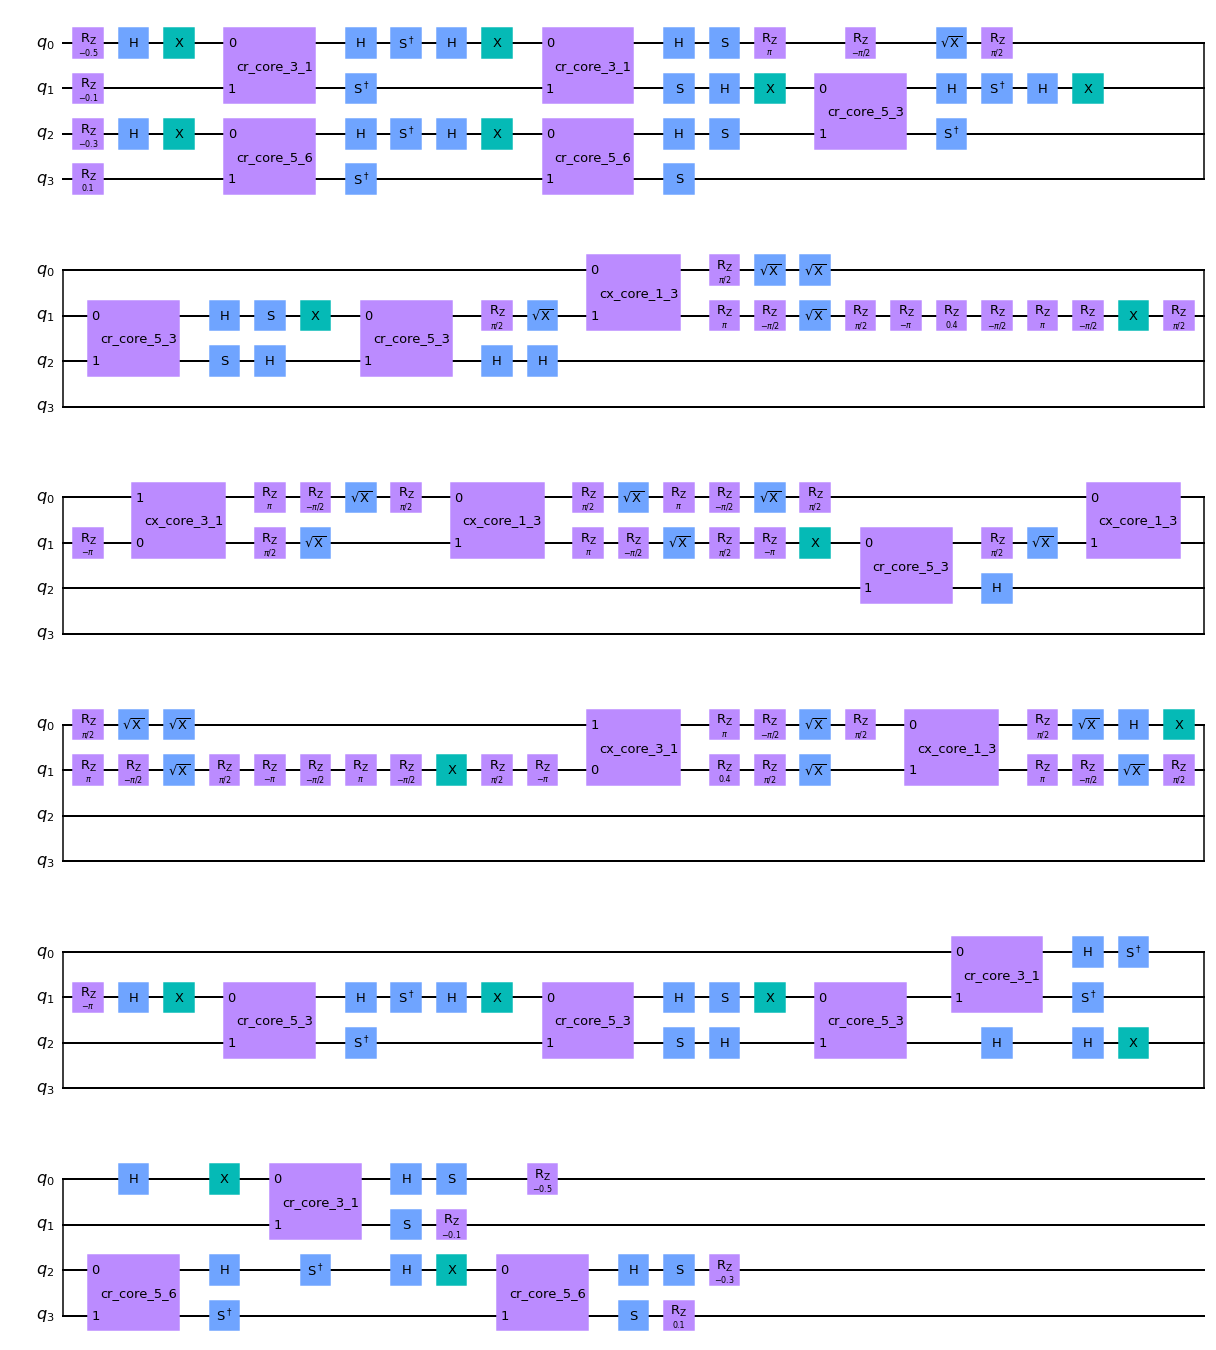

In [9]:
crs = {
    (0, 1): LinearizedCR(backend, (1, 3)),
    (1, 2): LinearizedCR(backend, (3, 5)),
    (2, 3): LinearizedCR(backend, (5, 6))
}
cxs = {
    (0, 1): cx_circuit(1, 3, backend),
    (1, 0): cx_circuit(3, 1, backend)
}
optimized_twostep_cr = two_steps(J, mu, omegadt, crs=crs, cxs=cxs)
optimized_twostep_cr.draw('mpl')

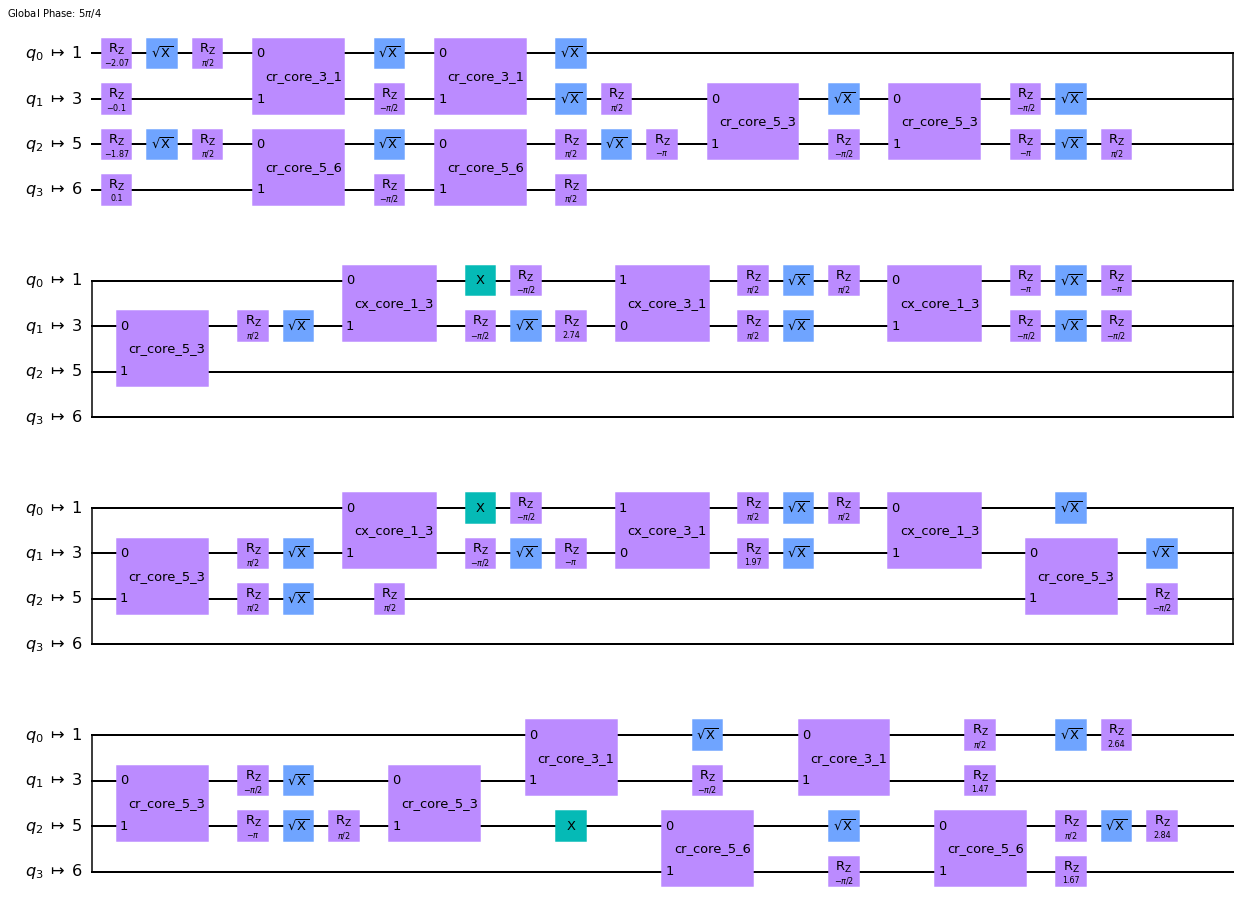

In [10]:
circuit = transpile(optimized_twostep_cr, backend=backend, initial_layout=[1, 3, 5, 6], optimization_level=1)
circuit.draw('mpl', idle_wires=False)